In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

In [9]:
"""
adjusted rating for A
adjusted rating for BBB
...

D : 금융투자업규정 제8-19조의9제3항제2호에 따라 원리금의 적기상환이 이루어지지 않거나 기업회생절차, 파산절차의 개시가 있는 경우에 부여하는 신용등급
WR(Withdrawal) : 연초에 신용등급이 존재하였으나 상환, 피흡수합병 등으로 등급이 소멸된 경우를 표시

"""

kis_2024_ctm = [
        [96.80,0.37,0,0,0,0,0,2.83],
        [1.49,76.37,3.71,.20,.05,.05,0,18.13],
        [.05,10.48,57.9,3.69,.32,.73,.27,26.56],
        [0,.16,13.56,34.92,2.22,2.38,1.81,44.95],
        [0,0,.98,5.46,17.93,2.38,9.94,63.31],
        [0,.20,.40,1.00,1.99,15.34,12.95,68.13],
    ]

states = ['AAA','AA','A','BBB','BB','B','D','WR']
index = ['AAA','AA','A','BBB','BB','B']
kis_2024_ctm = pd.DataFrame(kis_2024_ctm, columns=states,index=index)/100

In [10]:
wradj_kis_2024_ctm = np.zeros([kis_2024_ctm.shape[0],kis_2024_ctm.shape[1]])

In [11]:
wradj_kis_2024_ctm = pd.DataFrame(wradj_kis_2024_ctm, columns=states,index=index).drop('WR', axis=1,inplace=False)

# redistribute probabilities of WR state

In [12]:
for state in states:
    if state == 'D' or state == 'WR':
        break
    
    # unity minus withdrawal
    unity_min_wr = 1 - kis_2024_ctm.loc[state,'WR']
    
    for nxt_state in states:
        if nxt_state == 'WR':
            break
        adj_prob = kis_2024_ctm.loc[state,nxt_state] +\
            kis_2024_ctm.loc[state,'WR'] * kis_2024_ctm.loc[state,nxt_state] / unity_min_wr
        
        wradj_kis_2024_ctm.loc[state,nxt_state] = adj_prob
    """
    aaa/aaa + aaa/wr * aaa/aaa / unity minus withdrawal
    """
    

In [13]:
wradj_kis_2024_ctm = round(wradj_kis_2024_ctm,4)

In [14]:
# manual adjustment
wradj_kis_2024_ctm.loc['AA','AA'] = .9329
wradj_kis_2024_ctm.loc['BBB','BBB'] = .6344
wradj_kis_2024_ctm.loc['B','B'] = .4810

# add row
wradj_kis_2024_ctm.loc[len(wradj_kis_2024_ctm)] = [0,0,0,0,0,0,1]
wradj_kis_2024_ctm.index = ['AAA','AA','A','BBB','BB','B','D']
wradj_kis_2024_ctm.to_csv('wradj_kis_2024_ctm.csv', index=True, header=True)

# read from complete data

In [15]:
ctm = pd.read_csv('wradj_kis_2024_ctm.csv', index_col=0)
ctm

,AAA,AA,A,BBB,BB,B,D
AAA,0.9962,0.0038,0.0000,0.0000,0.0000,0.0000,0.0000
AA,0.0182,0.9329,0.0453,0.0024,0.0006,0.0006,0.0000
A,0.0007,0.1427,0.7884,0.0502,0.0044,0.0099,0.0037
BBB,0.0000,0.0029,0.2463,0.6344,0.0403,0.0432,0.0329
BB,0.0000,0.0000,0.0267,0.1488,0.4887,0.0649,0.2709
B,0.0000,0.0063,0.0126,0.0314,0.0624,0.4810,0.4063
D,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [20]:
discount_rate = .06
years_int = 3
principal = 10000
coupon = .07
interest = principal * coupon
recovery_rate = .4                  # recovery rate of principal in case of default
current_rating = 'BBB'
# next year default rate if possible ...

cash_flow_history = []
cash_flow_history_pv = []
npv_history = []
replications = 10000
default_count = 0
rating_history = []
rating = current_rating

for i in range(replications):
    
    ratings_ith_record = []         # records for ith iteration
    cf_ith_record = []              # cash flow records for ith iteration
    cf_ith_record_pv = []   
    rating = current_rating
    
    for j in range(years_int):
        
        # random choice from probability distribution ctm, rating of current rating
        
        prob = ctm.loc[rating, :].values
        rating = np.random.choice(a=ctm.columns, p=prob)
        
        
        if rating == 'D':
            default_count += 1
            ratings_ith_record.append('D')
            rating_history.append(ratings_ith_record)
            
            # if default, append recovered principal to cash flow records
            cf_j = principal * recovery_rate
            cf_ith_record.append(cf_j)
            cf_j_pv = cf_j / ((1 + discount_rate) ** (j+1))
            cf_ith_record_pv.append(cf_j_pv)
            break
        else:
            ratings_ith_record.append(rating)
            
            # if not default, append interest to cash flow records
            cf_j = interest
            cf_ith_record.append(cf_j)
            cf_j_pv = cf_j / ((1 + discount_rate) ** (j+1))
            cf_ith_record_pv.append(cf_j_pv)
            
            if j == years_int - 1:
                # if last year, append principal to cash flow records
                cf_j = principal
                cf_ith_record.append(cf_j)
                cf_j_pv = cf_j / ((1 + discount_rate) ** (j+1))
                cf_ith_record_pv.append(cf_j_pv)
    
    
    rating_history.append(ratings_ith_record)
    cash_flow_history.append(cf_ith_record)
    cash_flow_history_pv.append(cf_ith_record_pv)
    npv_history.append(sum(cf_ith_record_pv))
    
    if (i+1)%100 == 0:
        print(f"{i+1}th iteration completed")
    

100th iteration completed
200th iteration completed
300th iteration completed
400th iteration completed
500th iteration completed
600th iteration completed
700th iteration completed
800th iteration completed
900th iteration completed
1000th iteration completed
1100th iteration completed
1200th iteration completed
1300th iteration completed
1400th iteration completed
1500th iteration completed
1600th iteration completed
1700th iteration completed
1800th iteration completed
1900th iteration completed
2000th iteration completed
2100th iteration completed
2200th iteration completed
2300th iteration completed
2400th iteration completed
2500th iteration completed
2600th iteration completed
2700th iteration completed
2800th iteration completed
2900th iteration completed
3000th iteration completed
3100th iteration completed
3200th iteration completed
3300th iteration completed
3400th iteration completed
3500th iteration completed
3600th iteration completed
3700th iteration completed
3800th ite

In [21]:
pd.Series(npv_history).mean()

np.float64(9492.821923467021)

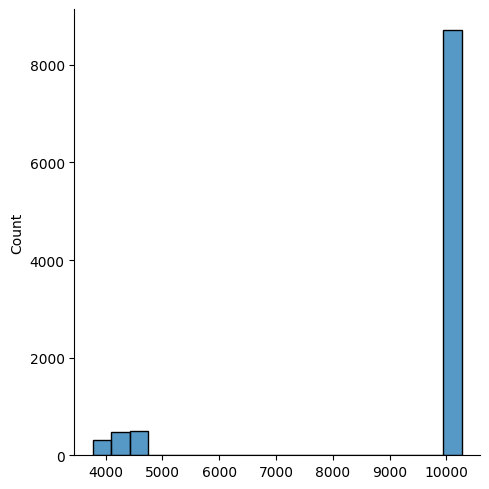

In [22]:
sns.displot(npv_history,bins=20)